# training an unsupervised VAE with APOGEE DR14 spectra
this notebooke takes you through the building and training of a fairly deep VAE. I have not actually done too much work with DR14, so it may pose some potential difficulties, but this should be a good start. The training is suited to be put into a python script and run from the command line.

If you're inclined, you may want to experiment with the model architecture, but I'm pretty sure this will work.

In [1]:
import numpy as np
import time
import h5py
import keras
import matplotlib.pyplot as plt

import sys

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Activation, 
                          Dropout, Conv1D, UpSampling1D, MaxPooling1D, ZeroPadding1D, LeakyReLU)
from keras.engine.topology import Layer
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K

plt.switch_backend('agg')

Using TensorFlow backend.


### load data
this is file dependent

this particular function expects the dr14 h5 file that can be downloaded from vos:starnet/public

In [2]:
# Define edges of detectors (for APOGEE)
blue_chip_begin = 322
blue_chip_end = 3242
green_chip_begin = 3648
green_chip_end = 6048   
red_chip_begin = 6412
red_chip_end = 8306 

# function for loading data
def load_train_data_weighted(data_file,indices=None):
    
    # grab all
    if indices is None:
        with h5py.File(data_file,"r") as F:
            ap_spectra = F['spectrum'][:]
            ap_err_spectra = F['error_spectrum'][:]
    # grab a batch
    else:            
        with h5py.File(data_file, "r") as F:
            indices_bool = np.ones((len(F['spectrum']),),dtype=bool)
            indices_bool[:] = False
            indices_bool[indices] = True 

            ap_spectra = F['spectrum'][indices_bool,:]
            ap_err_spectra = F['error_spectrum'][indices_bool,:]
            
    # combine chips        
    ap_spectra = np.hstack((ap_spectra[:,blue_chip_begin:blue_chip_end],
                                     ap_spectra[:,green_chip_begin:green_chip_end],
                                     ap_spectra[:,red_chip_begin:red_chip_end]))
    # set nan values to zero
    ap_spectra[np.isnan(ap_spectra)]=0.


    ap_err_spectra = np.hstack((ap_err_spectra[:,blue_chip_begin:blue_chip_end],
                                     ap_err_spectra[:,green_chip_begin:green_chip_end],
                                     ap_err_spectra[:,red_chip_begin:red_chip_end]))
            
    

    return ap_spectra,ap_err_spectra

In [3]:
# function for reshaping spectra into appropriate format for CNN
def cnn_reshape(spectra):
    return spectra.reshape(spectra.shape[0],spectra.shape[1],1)

set some model hyper-parameters

In [4]:
img_cols, img_chns = 7214, 1  
num_fluxes=7214
input_shape=(num_fluxes,1)

# z_dims is the dimension of the latent space
z_dims = 64
batch_size = 64
epsilon_std = 1.0
learning_rate = 0.001
decay = 0.0
padding=u'same'
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.01)
bias_init = keras.initializers.Zeros()

## Zero-Augmentation


In an effort to evenly distribute the weighting of the VAE, throughout training, a *zero-augmentation* technique was applied to the training spectra samples - both synthetic and observed. The zero-augmentation is implemented as the first layer in the encoder where a zero-augmentation mask is sent as an input along with the input spectrum and the two are multiplied together. The zero-augmentation mask is the same size as the input spectrum vector and is composed of ones and zeros. For the APOGEE wave-grid, the spectral region is divided into seven *chunks* and for each input spectrum a random 0-3 of these chunks are assigned to be zeros while the remainder of the zero-augmentation mask is made up of ones. This means for a given spectrum, the input for training may be 4/7ths, 5/7ths, 6/7ths, or the entire spectrum. This augmentation is done randomly throughout training, meaning that each spectrum will be randomly assigned a different zero-augmentation mask at every iteration.

In [5]:
# zero-augmentation layer (a trick I use to input chunks of zeros into the input spectra)
class ZeroAugmentLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(ZeroAugmentLayer, self).__init__(**kwargs)

    def zero_agument(self, x_real, zero_mask):
        return x_real*zero_mask

    def call(self, inputs):
        x_real = inputs[0]
        zero_mask = inputs[1]
        x_augmented = self.zero_agument(x_real, zero_mask)

        return x_augmented

# a function for creating the zero-masks used during training
def create_zero_mask(spectra,min_chunks,max_chunks,chunk_size,dataset=None,ones_padded=False):
    if dataset is None:
        zero_mask = np.ones_like(spectra)
    elif dataset=='apogee':
        zero_mask = np.ones((spectra.shape[0],7214))
    elif dataset=='segue':
        zero_mask = np.ones((spectra.shape[0],3688))
    
    num_spec = zero_mask.shape[0]
    len_spec = zero_mask.shape[1]
    num_bins = len_spec/chunk_size
    remainder = len_spec%chunk_size
    spec_sizes = np.array([chunk_size for i in range(num_bins)])
    spec_sizes[-1]=spec_sizes[-1]+remainder
    

    num_bins_removed = np.random.randint(min_chunks,max_chunks+1,size=(num_spec,))
    for i, mask in enumerate(zero_mask):
        bin_indx_removed = np.random.choice(num_bins, num_bins_removed[i], replace=False)
        for indx in bin_indx_removed:
            if indx==0:
                mask[indx*spec_sizes[indx]:(indx+1)*spec_sizes[indx]]=0.
            else:
                mask[indx*spec_sizes[indx-1]:indx*spec_sizes[indx-1]+spec_sizes[indx]]=0.

    return zero_mask

# build encoder
takes spectra (x) and zero-augmentation mask as inputs and outputs latent distribution (z_mean and z_log_var)

In [6]:
def build_encoder(input_1,input_2):
    
    # zero-augment input spectrum
    x = ZeroAugmentLayer()([input_1,input_2])
    
    # first conv block
    x = Conv1D(filters=16, kernel_size=8, strides=1, kernel_initializer=kernel_init,
                   bias_initializer=bias_init, padding=padding)(x)
    x = LeakyReLU(0.1)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # second conv bloack
    x = Conv1D(filters=16, kernel_size=8, strides=1, kernel_initializer=kernel_init,
                   bias_initializer=bias_init, padding=padding)(x)
    x = LeakyReLU(0.1)(x)
    x = BatchNormalization()(x)
    
    # maxpooling layer and flatten
    x = MaxPooling1D(pool_size=4, strides=4, padding='valid')(x)  
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    
    # intermediate dense block
    x = Dense(256)(x)
    x = LeakyReLU(0.3)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # latent distribution output
    z_mean = Dense(z_dims)(x)
    z_log_var = Dense(z_dims)(x)
    
    
    return Model([input_1,input_2],[z_mean,z_log_var])


# function for obtaining a latent sample given a distribution
def sampling(args, latent_dim=z_dims, epsilon_std=epsilon_std):
    z_mean, z_log_var = args
    
    epsilon = K.random_normal(shape=(z_dims,),
                              mean=0., stddev=epsilon_std)
    
    return z_mean + K.exp(z_log_var) * epsilon

# build decoder
takes  z (latent variables) as an input and outputs a stellar spectrum

In [7]:
def build_decoder(inputs):
    
    # input fully-connected block
    x = Dense(256)(inputs)
    x = LeakyReLU(0.1)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # intermediate fully-connected block
    w = input_shape[0] // (2 ** 3)
    x = Dense(w * 16)(x)
    x = LeakyReLU(0.1)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # reshape for convolutional blocks
    x = Reshape((w, 16))(x)

    # first deconv block
    x = UpSampling1D(size=4)(x)
    x = Conv1D(kernel_initializer=kernel_init,bias_initializer=bias_init,padding="same", 
                   filters=16,kernel_size=8)(x)
    x = LeakyReLU(0.1)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    # zero-padding to get x in the right dimension to create the spectra
    x = ZeroPadding1D(padding=(2,1))(x)
    
    # second deconv block
    x = UpSampling1D(size=2)(x)
    x = Conv1D(kernel_initializer=kernel_init,bias_initializer=bias_init,padding="same", 
                   filters=16,kernel_size=8)(x)
    x = LeakyReLU(0.1)(x)
    x = BatchNormalization()(x)
    
    # output conv layer
    x = Conv1D(kernel_initializer=kernel_init,bias_initializer=bias_init,padding="same", 
                   filters=1,kernel_size=8,activation='linear')(x)

    return Model(inputs,x)

## build models

In [8]:
# encoder and predictor input placeholders
input_spec = Input(shape=input_shape)
input_mask = Input(shape=input_shape)

# error spectra placeholder
input_err_spec = Input(shape=input_shape)

# decoder input placeholder
input_z = Input(shape=(z_dims,))

model_name='vae_test'
start_e = 0

# if you want to continue training from a certain epoch, you can uncomment the load models lines 
# and comment out the build_encoder, build_decoder lines
'''
encoder  = keras.models.load_model('models/encoder_'+model_name+'_epoch_'+str(start_e)+'.h5',
                                    custom_objects={'ZeroAugmentLayer':ZeroAugmentLayer})
decoder = keras.models.load_model('models/decoder_'+model_name+'_epoch_'+str(start_e)+'.h5',
                                 custom_objects={'ZeroAugmentLayer':ZeroAugmentLayer})

'''
# encoder model
encoder = build_encoder(input_spec, input_mask)

# decoder layers
decoder = build_decoder(input_z)
#'''

encoder.summary()
decoder.summary()


# outputs for encoder
z_mean, z_log_var = encoder([input_spec, input_mask])

# sample from latent distribution given z_mean and z_log_var
z = Lambda(sampling, output_shape=(z_dims,))([z_mean, z_log_var])

# outputs for decoder
output_spec = decoder(z)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 7214, 1)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 7214, 1)      0                                            
__________________________________________________________________________________________________
zero_augment_layer_1 (ZeroAugme [(None, 7214, 1), (N 0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 7214, 16)     144         zero_augment_layer_1[0][0]       
__________

## create loss function

This VAE has two loss functions that are minimized simultaneously:

1. a weighted mean-squared-error to analyze the predicted spectra:
\begin{equation}
mse = \frac{1}{N}\sum{\frac{(x_{true}-x_{pred})^2}{(x_{err})^2}}
\end{equation}




2. a relative entropy, KL (Kullback–Leibler divergence) loss to keep the latent variables within a similar distribuition:
\begin{equation}
KL = \frac{1}{N}\sum{-\frac{1}{2}(1.0+z_{log\_var} - z_{avg}^2 - e^{z_{log\_var}})}
\end{equation}


In [9]:
# loss for evaluating the regenerated spectra and the latent distribution
class VAE_LossLayer_weighted(Layer):
    __name__ = u'vae_labeled_loss_layer'

    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(VAE_LossLayer_weighted, self).__init__(**kwargs)

    def lossfun(self, x_true, x_pred, z_avg, z_log_var, x_err):
        mse = K.mean(K.square((x_true - x_pred)/x_err))
        kl_loss_x = K.mean(-0.5 * K.sum(1.0 + z_log_var - K.square(z_avg) - K.exp(z_log_var), axis=-1))

        return mse + kl_loss_x

    def call(self, inputs):
        # inputs for the layer:
        x_true = inputs[0]
        x_pred = inputs[1]
        z_avg = inputs[2]
        z_log_var = inputs[3]
        x_err = inputs[4]
        
        # calculate loss
        loss = self.lossfun(x_true, x_pred, z_avg, z_log_var, x_err)
        
        # add loss to model
        self.add_loss(loss, inputs=inputs)
        
        # returned value not really used for anything
        return x_true
    
# dummy loss to give zeros, hence no gradients to train
# the real loss is computed as the layer shown above and therefore this dummy loss is just 
# used to satisfy keras notation when compiling the model
def zero_loss(y_true, y_pred):
    return K.zeros_like(y_true)

## build and compile model trainer

In [10]:
# create loss layer
vae_loss = VAE_LossLayer_weighted()([input_spec, output_spec, z_mean, z_log_var, input_err_spec])

# build trainer with spectra, zero-masks, and error spectra as inputs. output is the final loss layer
vae = Model(inputs=[input_spec, input_mask, input_err_spec], outputs=[vae_loss])

# compile trainer
vae.compile(loss=[zero_loss],
                         optimizer=Adam(lr=1.0e-4, beta_1=0.5))

vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 7214, 1)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 7214, 1)      0                                            
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 64), (None,  7421600     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 64)           0           model_1[1][0]                    
          

In [11]:
# a model that encodes and then decodes a spectrum (this is used to plot the intermediate results during training)
gen_x_to_x = Model([input_spec,input_mask], output_spec)
gen_x_to_x.compile(loss='mse',
                         optimizer=Adam(lr=1.0e-4, beta_1=0.5))

In [12]:
# a function to display the time remaining or elapsed
def time_format(t):
    m, s = divmod(t, 60)
    m = int(m)
    s = int(s)
    if m == 0:
        return u'%d sec' % s
    else:
        return u'%d min' % (m)
    
    
    
# function for training on a batch
def train_on_batch(x_batch,x_err_batch):    
    
    # create zero-augmentation mask for batch
    zero_mask = create_zero_mask(x_batch,0,3,1030,dataset=None,ones_padded=False)
    
    # train on batch
    loss = [vae.train_on_batch([cnn_reshape(x_batch),
                                           cnn_reshape(zero_mask),cnn_reshape(x_err_batch)],  
                                          cnn_reshape(x_batch))]

    losses = {'vae_loss': loss[0]}
    return losses

In [13]:
def fit_model(model_name, data_file, epochs, reporter):
    
    # get the number of spectra in the data_file
    with h5py.File(data_file, "r") as F:
            num_data_ap = len(F['spectrum'])
            
    # lets use 90% of the samples for training
    num_data_train_ap = int(num_data_ap*0.9)
    
    # the remainder will be grabbed for testing the model throughout training
    test_indices_range_ap = [num_data_train_ap,num_data_ap]
    
    
    # loop through the number of epochs
    for e in xrange(start_e,epochs):
        
        # create a randomized array of indices to grab batches of the spectra
        perm_ap = np.random.permutation(num_data_train_ap)        
        
        start_time = time.time()
        
        # loop through the batches 
        losses_=[]
        for b in xrange(0, num_data_train_ap, batchsize):         
            
            # determine current batch size
            bsize = min(batchsize, num_data_train_ap - b)
            
            # grab a batch of indices
            indx_batch = perm_ap[b:b+bsize]
            
            # load a batch of data
            x_batch, x_err_batch= load_train_data_weighted(data_file,indices=indx_batch)
            
            # train on batch
            losses = train_on_batch(x_batch,x_err_batch)
            
            losses_.append(losses)
            
            # Print current status
            ratio = 100.0 * (b + bsize) / num_data_train_ap
            print unichr(27) + u"[2K",; sys.stdout.write(u'')
            print u'\rEpoch #%d | %d / %d (%6.2f %%) ' % \
                  (e + 1, b + bsize, num_data_train_ap, ratio),; sys.stdout.write(u'')

            for k in reporter:
                if k in losses:
                    print u'| %s = %5.3f ' % (k, losses[k]),; sys.stdout.write(u'')

            # Compute ETA
            elapsed_time = time.time() - start_time
            eta = elapsed_time / (b + bsize) * (num_data_train_ap - (b + bsize))
            print u'| ETA: %s ' % time_format(eta),; sys.stdout.write(u'')

            sys.stdout.flush()

    
    
        print u''
        
        # Print epoch status
        ratio = 100.0
        print unichr(27) + u"[2K",; sys.stdout.write(u'')
        print u'\rEpoch #%d | %d / %d (%6.2f %%) ' % \
              (e + 1, num_data_train_ap, num_data_train_ap, ratio),; sys.stdout.write(u'')

        losses_all = {}
        for k in losses_[0].iterkeys():
            losses_all[k] = tuple(d[k] for d in losses_)
        for k in reporter:
            if k in losses_all:
                losses_all[k]=np.sum(losses_all[k])/len(losses_)
        for k in reporter:
            if k in losses_all:
                print u'| %s = %5.3f ' % (k, losses_all[k]),; sys.stdout.write(u'')
   

        # save loss to evaluate progress        
        myfile = open(model_name+'.txt', 'a')
        for k in reporter:
            if k in losses:
                myfile.write("%s," % losses[k])
        myfile.write("\n")
        myfile.close()    
            
        # Compute Time Elapsed
        elapsed_time = time.time() - start_time
        eta = elapsed_time
        print u'| TE: %s ' % time_format(eta),; sys.stdout.write(u'')

        #sys.stdout.flush()
        print('\n')
        
        
        # save models
        encoder.save('models/encoder_'+model_name+'_epoch_'+str(e)+'.h5')
        decoder.save('models/decoder_'+model_name+'_epoch_'+str(e)+'.h5')
        
        
        # plot results for a test set to evaluate how the vae is able to reproduce a spectrum
        test_sample_indices = np.random.choice(range(test_indices_range_ap[0],test_indices_range_ap[1]), 5, replace=False)
        sample_orig,_, = load_train_data_weighted(data_file,indices=test_sample_indices)
        zero_mask_test = create_zero_mask(sample_orig,0,3,1030)
        test_x = gen_x_to_x.predict([cnn_reshape(sample_orig),cnn_reshape(zero_mask_test)])
        sample_orig_aug = sample_orig*zero_mask_test
        
        sample_diff = sample_orig-test_x.reshape(test_x.shape[0],test_x.shape[1])

        
        # save test results
        fig, axes = plt.subplots(20,1,figsize=(70, 20))
        for i in range(len(test_sample_indices)):
            # original spectrum
            axes[i*4].plot(sample_orig[i],c='r')
            axes[i*4].set_ylim((0.4,1.2))
            # input zero-augmented spectrum
            axes[1+4*i].plot(sample_orig_aug[i],c='g')
            axes[1+4*i].set_ylim((0.4,1.2))
            # regenerated spectrum
            axes[2+4*i].plot(test_x[i],c='b')
            axes[2+4*i].set_ylim((0.4,1.2))
            # residual between original and regenerated spectra
            axes[3+4*i].plot(sample_diff[i],c='m')
            axes[3+4*i].set_ylim((-0.3,0.3))
        # save results
        plt.savefig('results/test_sample_ap_'+model_name+'_epoch_'+str(e)+'.jpg')
        plt.close('all')

# train model

you can experiment with the number of epochs. I suggest starting with fewer and seeing if the results are adequate. if not, continue training. The models and results are saved in models/ and results/ after each epoch, so you can run analyses throughout training.

In [ ]:
reporter=['vae_loss']
epochs=30
batchsize=64
if start_e>0:
    start_e=start_e+1

data_file = '/data/stars/aspcapStar_combined_main_dr14.h5'

fit_model(model_name,data_file, epochs,reporter)

Epoch #1 | 24896 / 233481 ( 10.66 %)  | vae_loss = 5541.463  | ETA: 201 min  [2K                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## analyze results

Note, this is a dummy result. I haven't trained the models for a proper epoch yet

In [1]:
import numpy as np
import h5py
import keras
import matplotlib.pyplot as plt

import sys

from keras.layers import (Input, Lambda)
from keras.engine.topology import Layer
from keras import backend as K


%matplotlib inline

Using TensorFlow backend.


In [2]:
# Define edges of detectors (for APOGEE)
blue_chip_begin = 322
blue_chip_end = 3242
green_chip_begin = 3648
green_chip_end = 6048   
red_chip_begin = 6412
red_chip_end = 8306 

# function for loading data
def load_train_data_weighted(data_file,indices=None):
    
    # grab all
    if indices is None:
        with h5py.File(data_file,"r") as F:
            ap_spectra = F['spectrum'][:]
            ap_err_spectra = F['error_spectrum'][:]
    # grab a batch
    else:            
        with h5py.File(data_file, "r") as F:
            indices_bool = np.ones((len(F['spectrum']),),dtype=bool)
            indices_bool[:] = False
            indices_bool[indices] = True 

            ap_spectra = F['spectrum'][indices_bool,:]
            ap_err_spectra = F['error_spectrum'][indices_bool,:]
            
    # combine chips        
    ap_spectra = np.hstack((ap_spectra[:,blue_chip_begin:blue_chip_end],
                                     ap_spectra[:,green_chip_begin:green_chip_end],
                                     ap_spectra[:,red_chip_begin:red_chip_end]))
    # set nan values to zero
    ap_spectra[np.isnan(ap_spectra)]=0.


    ap_err_spectra = np.hstack((ap_err_spectra[:,blue_chip_begin:blue_chip_end],
                                     ap_err_spectra[:,green_chip_begin:green_chip_end],
                                     ap_err_spectra[:,red_chip_begin:red_chip_end]))
            
    

    return ap_spectra,ap_err_spectra


# zero-augmentation layer (a trick I use to input chunks of zeros into the input spectra)
class ZeroAugmentLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(ZeroAugmentLayer, self).__init__(**kwargs)

    def zero_agument(self, x_real, zero_mask):
        return x_real*zero_mask

    def call(self, inputs):
        x_real = inputs[0]
        zero_mask = inputs[1]
        x_augmented = self.zero_agument(x_real, zero_mask)

        return x_augmented

# a function for creating the zero-masks used during training
def create_zero_mask(spectra,min_chunks,max_chunks,chunk_size,dataset=None,ones_padded=False):
    if dataset is None:
        zero_mask = np.ones_like(spectra)
    elif dataset=='apogee':
        zero_mask = np.ones((spectra.shape[0],7214))
    elif dataset=='segue':
        zero_mask = np.ones((spectra.shape[0],3688))
    
    num_spec = zero_mask.shape[0]
    len_spec = zero_mask.shape[1]
    num_bins = len_spec/chunk_size
    remainder = len_spec%chunk_size
    spec_sizes = np.array([chunk_size for i in range(num_bins)])
    spec_sizes[-1]=spec_sizes[-1]+remainder
    

    num_bins_removed = np.random.randint(min_chunks,max_chunks+1,size=(num_spec,))
    for i, mask in enumerate(zero_mask):
        bin_indx_removed = np.random.choice(num_bins, num_bins_removed[i], replace=False)
        for indx in bin_indx_removed:
            if indx==0:
                mask[indx*spec_sizes[indx]:(indx+1)*spec_sizes[indx]]=0.
            else:
                mask[indx*spec_sizes[indx-1]:indx*spec_sizes[indx-1]+spec_sizes[indx]]=0.

    return zero_mask

# function for reshaping spectra into appropriate format for CNN
def cnn_reshape(spectra):
    return spectra.reshape(spectra.shape[0],spectra.shape[1],1)

In [3]:
losses = np.zeros((1,))
with open("vae_test.txt", "r") as f:
    for i,line in enumerate(f):
        currentline = np.array(line.split(",")[0],dtype=float)
        if i ==0:
            losses[0]=currentline.reshape((1,))
        else:
            losses = np.hstack((losses,currentline.reshape((1,))))

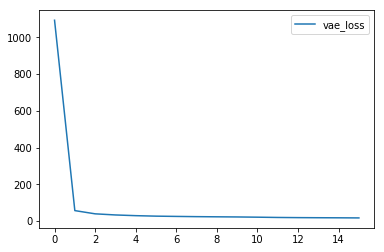

In [4]:
plt.plot(losses[0:16],label='vae_loss')
plt.legend()
plt.show()

In [5]:
# function for encoding a spectrum into the latent space
def encode_spectrum(model_name,epoch,spectra):

    encoder  = keras.models.load_model('models/encoder_'+model_name+'_epoch_'+str(epoch)+'.h5',
                                    custom_objects={'ZeroAugmentLayer':ZeroAugmentLayer})
    z_avg,z_log_var = encoder.predict([cnn_reshape(spectra),cnn_reshape(np.ones_like(spectra))])
    
    return z_avg, z_log_var

In [6]:
data_file = '/data/stars/aspcapStar_combined_main_dr14.h5'

test_range = [0,30000]


test_sample_indices = np.random.choice(range(0,30000), 5000, replace=False)
sample_x,_, = load_train_data_weighted(data_file,indices=test_sample_indices)     

In [7]:
model_name = 'vae_test'
epoch=16

z_avg, z_log_var = encode_spectrum(model_name,epoch,sample_x)

/opt/conda/lib/python2.7/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## t-sne

an example of an unsupervised clustering method on the latent space.

In [8]:
from tsne import bh_sne


perplex=80

t_data = z_avg

# convert data to float64 matrix. float64 is need for bh_sne
t_data = np.asarray(t_data).astype('float64')
t_data = t_data.reshape((t_data.shape[0], -1))

In [9]:
# perform t-SNE embedding
vis_data = bh_sne(t_data, perplexity=perplex)

In [10]:
# separate 2D into x and y axes information
vis_x = vis_data[:, 0]
vis_y = vis_data[:, 1]

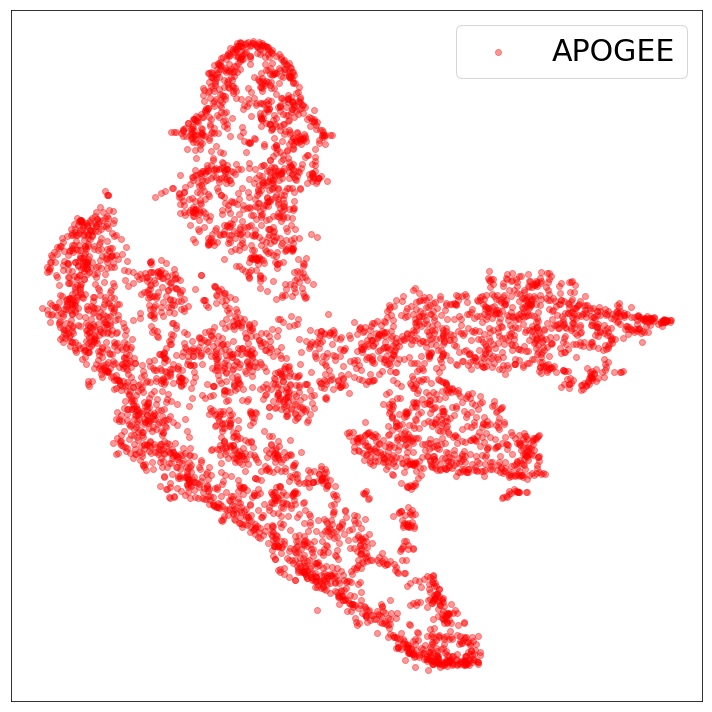

In [11]:
fig = plt.figure(figsize=(10, 10))
synth_ap = plt.scatter(vis_x, vis_y, marker='o', c='r',label='APOGEE', alpha=0.4)


plt.tick_params(
    axis='x',         
    which='both',      
    bottom='off',      
    top='off',         
    labelbottom='off')

plt.tick_params(
    axis='y',         
    which='both',      
    right='off',      
    left='off',         
    labelleft='off')

plt.legend(fontsize=30)
plt.tight_layout()
plt.show()

you could also use a colour gradient based on, say, the star's Teff to see how hot and cool stars clump together